# Check if speculative execution works

In [7]:
from plotnine import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import os
import random
import json
import re
import datetime
from io import StringIO

In [2]:
!ls

calculate_weight.py	     script.py		     STATS.first.speculative
CMakeLists.txt		     simulation.cxx	     STATS.jean-zay-small
p2p-vs-pfs		     simulation.py	     test-elasticity
__pycache__		     Speculative-Test.ipynb  Traces.ipynb
README.md		     STATS
script_assimilate_python.py  STATS.2


In [4]:
stats = 'STATS'
STATS = stats

In [45]:
data = !! ls $stats/runner*/trace.runner-*-app.0.csv
print(f'Found data from {len(data)} runners')
al = []

df_se = pd.read_csv(f'{stats}/select_events.melissa_p2p_server.csv')
df_se['used'] = False
used_entries = []
needed_transfers = 0
for i, line in enumerate(data):
    df = pd.read_csv(line)
    runner_id = int(re.search('runner-([0-9]{3})', line).groups()[0])

    df['id'] = runner_id    
    df['Assimilation cycle'] = -1
    df['Parent'] = -1
    df['start_time_s'] = df['start_time'] / 1000
    df['end_time_s'] = df['end_time'] / 1000


    df['state load'] = ''
    state_load = ''
    parent_t = -1
    parent_id = -1

    for i, row in df.iterrows(): 
        if row['region'] == '_LOAD':

            parent_t = row['parameter_open']
            parent_id = row['parameter_close']
        if row['region'] == 'Propagation':
            state_load = 'Cache hit'
            state_select = df_se[(df_se['runner_id'] == runner_id) & (df_se['used'] == False) & (df_se['state_t'] == parent_t) & (df_se['state_id'] == parent_id) & (df_se['time'] < row['start_time'])]

            if len(state_select) > 0:
                if state_select['was_cached'].iloc[0] == 0:
                    used_entries.append(state_select.tail(1))
                    state_load = 'Cache miss'
                    #if xmin < row['start_time_s']  and row['end_time_s'] < xmax:
                    needed_transfers += 1
                df_se.loc[df_se['time'] == state_select['time'].iloc[0], 'used'] = True


            df.at[i,'Parent'] = parent_id
            df.at[i,'state load'] = state_load
            df.at[i,'Assimilation cycle'] = parent_t + 1





        if row['region'] == 'Propagation':
            last_parent_id = parent_id


    al.append(df)

#print('percentage of necessary state transfers:', needed_transfers / a * 100)

df_all_runners2 = pd.concat(al)
df_all_runners2['Assimilation_cycle'] = df_all_runners2['Assimilation cycle']

Found data from 4 runners


In [46]:
df_all_runners2

rank    start_time      end_time                region  parameter_open  \
0       0   6494.453399   7398.229445           Propagation               0   
1       0   6486.678481   7398.243367                 _INIT               0   
2       0   7398.284100   7442.212716                _STORE               0   
3       0   7442.218434   7776.214087          _CALC_WEIGHT               0   
4       0   7776.235255   7776.852018  _PUSH_WEIGHT_TO_HEAD               0   
..    ...           ...           ...                   ...             ...   
798     0  60690.850409  60691.327053          _JOB_REQUEST               0   
799     0  60691.330326  60692.547284          _CHECK_LOCAL              25   
800     0  60691.328499  60696.069856                 _LOAD              25   
801     0  60649.000790  60696.090041           Runner idle               3   
802     0  60696.090838  61297.229743           Propagation             721   

     parameter_close  id  Assimilation cycle  Parent  start_time_s  \
0                  0   0                   0      -1      6.494453   
1                  0   0                  -1      -1      6.486678   
2                  0   0                  -1      -1      7.398284   
3                  0   0                  -1      -1      7.442218   
4                  0   0                  -1      -1      7.776235   
..               ...  ..                 ...     ...           ...   
798              721   3                  -1      -1     60.690850   
799              705   3                  -1      -1     60.691330   
800              705   3                  -1      -1     60.691328   
801                3   3                  -1      -1     60.649001   
802              721   3                  26     705     60.696091   

     end_time_s state load  Assimilation_cycle  
0      7.398229  Cache hit                   0  
1      7.398243                             -1  
2      7.442213                             -1  
3      7.776214                             -1  
4      7.776852                             -1  
..          ...        ...                 ...  
798   60.691327                             -1  
799   60.692547                             -1  
800   60.696070                             -1  
801   60.696090                             -1  
802   61.297230  Cache hit                  26  

[3178 rows x 13 columns]

/home/friese/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 4 in image.
/home/friese/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/friese/tmp/speculative_test.png


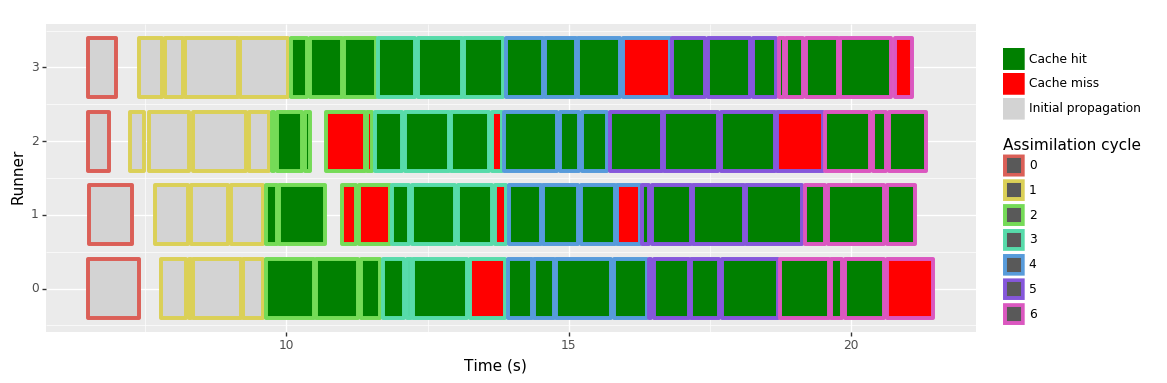

<ggplot: (8744297882471)>

In [48]:
df_all_runners2['state_load'] = df_all_runners2['state load']
df_all_runners2.loc[df_all_runners2['Assimilation_cycle'] <=1, 'state_load'] = 'Initial propagation'
p = ggplot(df_all_runners2[(df_all_runners2['region'] == 'Propagation') & (df_all_runners2['Assimilation_cycle'] < 7)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1.6)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

#p += xlim(0,970)



p += theme(figure_size = (12, 4))
p += labs(fill='')
p += labs(color='Assimilation cycle')


ggsave(p, '/home/friese/tmp/speculative_test.png')
p

                          

In this example (4 runners, 15 Particles) the walltime of each iteration is mainly given by a random sleep:
```c
            uint32_t sd = rand()%1000 * 1000;
            usleep(sd);
```
Meaning that the propagation time is distributed approximately uniformly between between 0.001 and 1 second + some overhead

It is visible that speculative propagation works. Still there are some holes in the schedule during the 2nd Assimiltion cycle that need to be investigated further.

Also was the weight of every member fixed to 0.42 to test without a meaning ful weight function. Maybe in other cases the weight will play an other role leading to more than 15 particles that will effectively be executed per cycle - In this case speculative propagation with the used residual resampling works so great that no unuseful particles are propagated. (All particles that are propagated speculatively are used)

Due to caching / *prescheduling* it can happen that a speculative particle starts even if there would be a particle left to be exectued this iteration (see runner 2, assimilation cycle 4)

# Plot with some more members

In [83]:
stats = 'STATS'
STATS = stats

In [89]:
data = !! ls $stats/runner*/trace.runner-*-app.0.csv
print(f'Found data from {len(data)} runners')
al = []

df_se = pd.read_csv(f'{stats}/select_events.melissa_p2p_server.csv')
df_se['used'] = False
used_entries = []
needed_transfers = 0
for i, line in enumerate(data):
    df = pd.read_csv(line)
    runner_id = int(re.search('runner-([0-9]{3})', line).groups()[0])

    df['id'] = runner_id    
    df['Assimilation cycle'] = -1
    df['Parent'] = -1
    df['start_time_s'] = df['start_time'] / 1000
    df['end_time_s'] = df['end_time'] / 1000


    df['state load'] = ''
    state_load = ''
    parent_t = -1
    parent_id = -1

    for i, row in df.iterrows(): 
        if row['region'] == '_LOAD':

            parent_t = row['parameter_open']
            parent_id = row['parameter_close']
        if row['region'] == 'Propagation':
            state_load = 'Cache hit'
            state_select = df_se[(df_se['runner_id'] == runner_id) & (df_se['used'] == False) & (df_se['state_t'] == parent_t) & (df_se['state_id'] == parent_id) & (df_se['time'] < row['start_time'])]

            if len(state_select) > 0:
                if state_select['was_cached'].iloc[0] == 0:
                    used_entries.append(state_select.tail(1))
                    state_load = 'Cache miss'
                    #if xmin < row['start_time_s']  and row['end_time_s'] < xmax:
                    needed_transfers += 1
                df_se.loc[df_se['time'] == state_select['time'].iloc[0], 'used'] = True


            df.at[i,'Parent'] = parent_id
            df.at[i,'state load'] = state_load
            df.at[i,'Assimilation cycle'] = parent_t + 1





        if row['region'] == 'Propagation':
            last_parent_id = parent_id


    al.append(df)

#print('percentage of necessary state transfers:', needed_transfers / a * 100)

df_all_runners2 = pd.concat(al)
df_all_runners2['Assimilation_cycle'] = df_all_runners2['Assimilation cycle']

Found data from 4 runners


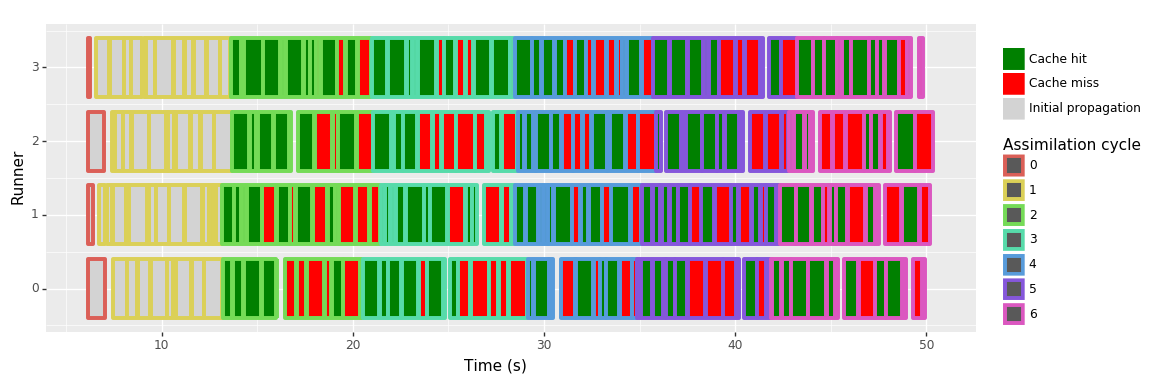

<ggplot: (8744365150727)>

In [90]:
df_all_runners2['state_load'] = df_all_runners2['state load']
df_all_runners2.loc[df_all_runners2['Assimilation_cycle'] <=1, 'state_load'] = 'Initial propagation'
p = ggplot(df_all_runners2[(df_all_runners2['region'] == 'Propagation') & (df_all_runners2['Assimilation_cycle'] < 7)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1.6)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

#p += xlim(0,60)



p += theme(figure_size = (12, 4))
p += labs(fill='')
p += labs(color='Assimilation cycle')


p


Why are there much more holes when using much moreparticles?
- frist holes could be fixed by moving to shm (my ssd seems not to be as performant as ramdisk... that makes sense)

In [91]:
data1 = !! grep -h REQ $stats/*/trace.runner-*-app.0.csv 
data2 = !! grep -h PUSH_WEIGHT_TO_SERVER $stats/*/trace.runner-*-head.0.csv 
data3 = !! grep -h REQ $stats/*/trace.runner-*-head.0.csv 
al = data1 + data2 + data3

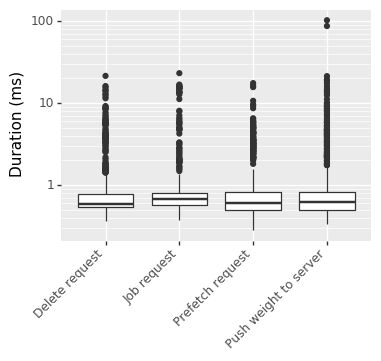

<ggplot: (8744321363890)>

In [92]:
df_req = pd.read_csv(StringIO('\n'.join(al)), names=["rank", "start_time", "end_time", "region", "parameter_open", "parameter_close"])
df_req['Duration (ms)'] = (df_req['end_time'] - df_req['start_time'])
df_req = df_req[df_req['region'] != '_REQ_RUNNER_LIST']
df_req.loc[df_req['region'] == '_DELETE_REQ', 'region'] = 'Delete request'
df_req.loc[df_req['region'] == '_PREFETCH_REQ', 'region'] = 'Prefetch request'
df_req.loc[df_req['region'] == '_PUSH_WEIGHT_TO_SERVER', 'region'] = 'Push weight to server'
df_req.loc[df_req['region'] == '_JOB_REQUEST', 'region'] = 'Job request'


p = ggplot(df_req)
p += geom_boxplot(aes(x='region', y='Duration (ms)'))
p += theme(axis_text_x=element_text(rotation=45, hjust=1))
p += scale_y_log10()
#p += ggtitle("Server response time")
p += labs(x='')

p += theme(figure_size = (4, 3))
p

The Server seems not to be the reason.

In [93]:
runner = '000'
t_pull = 'Load state from PFS into cache'
t_push = 'Write state from cache into PFS'
t_local = 'Load state from cache'

df_head = pd.read_csv(f'{STATS}/runner-{runner}/trace.runner-{runner}-head.0.csv')
df_head['duration (ms)'] = df_head['end_time'] - df_head['start_time']
df_head['process'] = 'helper process'
df_app = pd.read_csv(f'{STATS}/runner-{runner}/trace.runner-{runner}-app.0.csv')
df_app['process'] = 'model process'
df_app = df_app[df_app['region'] != '_WAIT_HEAD']
df_app['cat'] = df_app['region'].copy()
df_app.loc[df_app['region'] == '_CALC_WEIGHT', 'region'] = 'Weight calculation'
df_app.loc[df_app['region'] == '_CHECK_LOCAL', 'region'] = 'check if parent state local'
df_app.loc[df_app['region'] == '_STORE', 'region'] = 'copy model state\ninto local ram disk'
df_app.loc[df_app['region'] == '_PUSH_WEIGHT_TO_HEAD', 'region'] = 'send weight\nto worker processes'
df_app.loc[df_app['region'] == '_INIT', 'region'] = 'init'
df_app.loc[df_app['region'] == '_JOB_REQUEST', 'region'] = 'Request job from server'
df_app.loc[df_app['region'] == '_LOAD', 'region'] = t_local
df_app.loc[df_app['region'] == 'Propagation', 'region'] = "Propagation"
df_head.loc[df_head['region'] == '_DELETE_REQ', 'region'] = 'delete request'
df_head.loc[df_head['region'] == '_PREFETCH_REQ', 'region'] = 'prefetch request'
df_head.loc[df_head['region'] == '_PUSH_WEIGHT_TO_SERVER', 'region'] = 'push weight to server'
df_head.loc[df_head['region'] == '_JOB_REQUEST', 'region'] = 'job request'
df_head.loc[df_head['region'] == '_COPY_STATE_FROM_PFS', 'region'] = t_pull
df_head.loc[df_head['region'] == '_PUSH_STATE_TO_PFS', 'region'] = t_push





df_app['oo'] = 1
df_head['oo'] = 1
good_cats = ['Weight calculation', 'runner idle', 'Request job from server', 'Propagation', t_local, t_pull, t_push]
for idx, cat in enumerate(good_cats):
    df_app.loc[df_app['region'] == cat, 'oo'] = -idx
    df_head.loc[df_head['region'] == cat, 'oo'] = -idx
    
df_all = pd.concat([df_app, df_head])
df_all['start_time_s'] = df_all['start_time']/1000
df_all['end_time_s'] = df_all['end_time']/1000

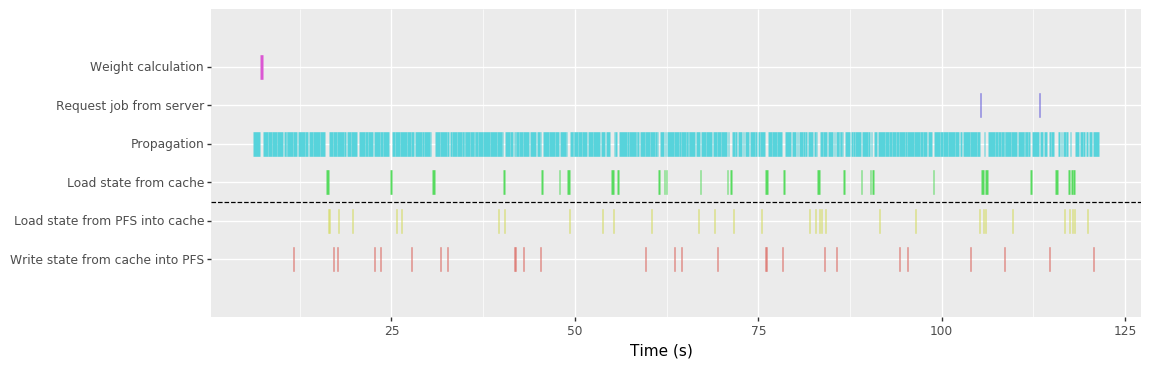

<ggplot: (8744352217176)>

In [94]:

# runner trace
p = ggplot(df_all[df_all['region'].isin(good_cats)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='reorder(region, oo)',
                   ymax='reorder(region, oo)',
                   fill='reorder(region, oo)', colour='reorder(region, oo)',
                  ), 
               size=10, alpha=1)
#p += ggtitle("Runner trace")
p += guides(fill=False, colour=False)
p += xlab('Time (s)')
p += theme(figure_size = (12, 4))
#p += geom_mark_rect(aes(fill = 'process', filter = 'process'))

xs = 377
xe = 530.5
xxx=xe + 40

# p += annotate("label", x=xxx, y=5, label="Model\n processes ", angle=90)
# p += annotate("label", x=xxx, y=1, label="Helper\n processes ", angle=90)


p += geom_hline(aes(yintercept=2.5),  linetype = "dashed")


# p += geom_segment(x=xs, y=3.5, xend=xs, yend=4, arrow=arrow(length=0.1, type='open'),size = 0.1)
# p += geom_segment(x=xe, y=3.5, xend=xe, yend=4, arrow=arrow(length=0.1, type='open'),size = 0.1)

# p += geom_vline(xintercept=xs)
# p += geom_vline(xintercept=xe)
# p += geom_segment(x=xs, y=7, xend=xe, yend=7,size = 0.1)
# p += annotate("label", x=(xe-xs)/2 + xs, y=7, label="Assimilation cycle")


#p += xlim(260,600)
p += scale_y_discrete(expand=(0,1.5, 0,1.5))
p += ylab('')
p

So cache loads take way too much time.

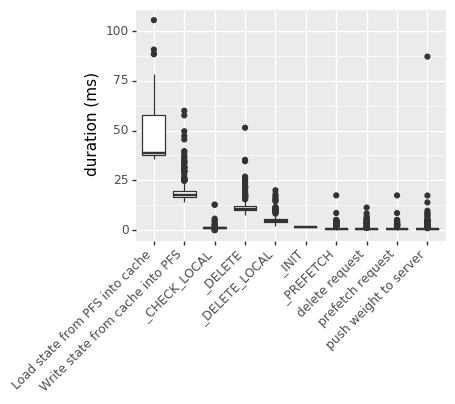

<ggplot: (8744352183179)>

In [95]:

# p2p vs pfs
df_head['category'] = df_head['region']

p = ggplot(df_head[(df_head['region'] == t_pull) | (df_head['region'] ==  t_push) | (df_head['region'] == t_local) ])
p = ggplot(df_head)
p += geom_boxplot(aes(x='category', y='duration (ms)'))
#p += ggtitle("State copy")

p += xlab('')
p += theme(figure_size = (4, 3))
p += theme(axis_text_x=element_text(rotation=45, hjust=1))
#p += ylim(0, 1e4)
#ggsave(p, '/home/friese/phd/melissa-p2p/arch/images/pfs_times.pdf')


p
# TODO: chart with all the server times req times von app core und head. Done

Still we get some fs errors. probably fs not fast enough on my local machine. need to test now on jean-zay!

# 23.8.2021: First run on jean-zay

In [8]:
def preprocess(stats):
    STATS = stats
    data = !! ls $stats/runner*/trace.runner-*-app.0.csv
    print(f'Found data from {len(data)} runners')
    al = []

    df_se = pd.read_csv(f'{stats}/select_events.melissa_p2p_server.csv')
    df_se['used'] = False
    used_entries = []
    needed_transfers = 0
    for i, line in enumerate(data):
        df = pd.read_csv(line)
        runner_id = int(re.search('runner-([0-9]{3})', line).groups()[0])

        df['id'] = runner_id    
        df['Assimilation cycle'] = -1
        df['Parent'] = -1
        df['start_time_s'] = df['start_time'] / 1000
        df['end_time_s'] = df['end_time'] / 1000


        df['state load'] = ''
        state_load = ''
        parent_t = -1
        parent_id = -1

        for i, row in df.iterrows(): 
            if row['region'] == '_LOAD':

                parent_t = row['parameter_open']
                parent_id = row['parameter_close']
            if row['region'] == 'Propagation':
                state_load = 'Cache hit'
                state_select = df_se[(df_se['runner_id'] == runner_id) & (df_se['used'] == False) & (df_se['state_t'] == parent_t) & (df_se['state_id'] == parent_id) & (df_se['time'] < row['start_time'])]

                if len(state_select) > 0:
                    if state_select['was_cached'].iloc[0] == 0:
                        used_entries.append(state_select.tail(1))
                        state_load = 'Cache miss'
                        #if xmin < row['start_time_s']  and row['end_time_s'] < xmax:
                        needed_transfers += 1
                    df_se.loc[df_se['time'] == state_select['time'].iloc[0], 'used'] = True


                df.at[i,'Parent'] = parent_id
                df.at[i,'state load'] = state_load
                df.at[i,'Assimilation cycle'] = parent_t + 1





            if row['region'] == 'Propagation':
                last_parent_id = parent_id


        al.append(df)

    #print('percentage of necessary state transfers:', needed_transfers / a * 100)

    df_all_runners2 = pd.concat(al)
    df_all_runners2['Assimilation_cycle'] = df_all_runners2['Assimilation cycle']
    df_all_runners2['state_load'] = df_all_runners2['state load']
    df_all_runners2.loc[df_all_runners2['Assimilation_cycle'] <=1, 'state_load'] = 'Initial propagation'
    return df_all_runners2

Found data from 2 runners


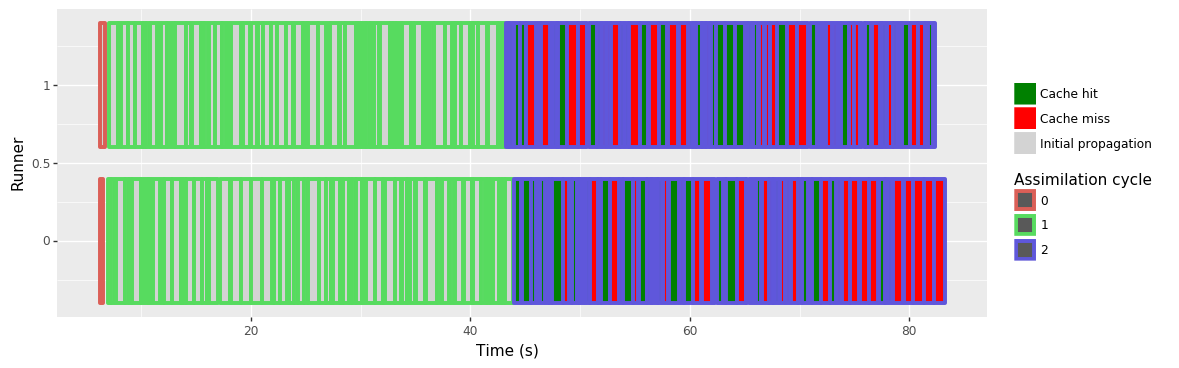

<ggplot: (8751146404615)>

In [19]:
o = preprocess('STATS.jean-zay/STATS.jean-zay-small/STATS')

p = ggplot(o[(o['region'] == 'Propagation') & (o['Assimilation_cycle'] < 3)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1.6)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

#p += xlim(0,60)



p += theme(figure_size = (12, 4))
p += labs(fill='')
p += labs(color='Assimilation cycle')


p

scheint auch mit groesser zu klappen. dann jetzt mal mehr runner....
lets do 1000 members, 20 runners

In [82]:
o = preprocess('STATS.jean-zay/STATS.1000')

Found data from 20 runners


/home/friese/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_rect : Removed 3197 rows containing missing values.


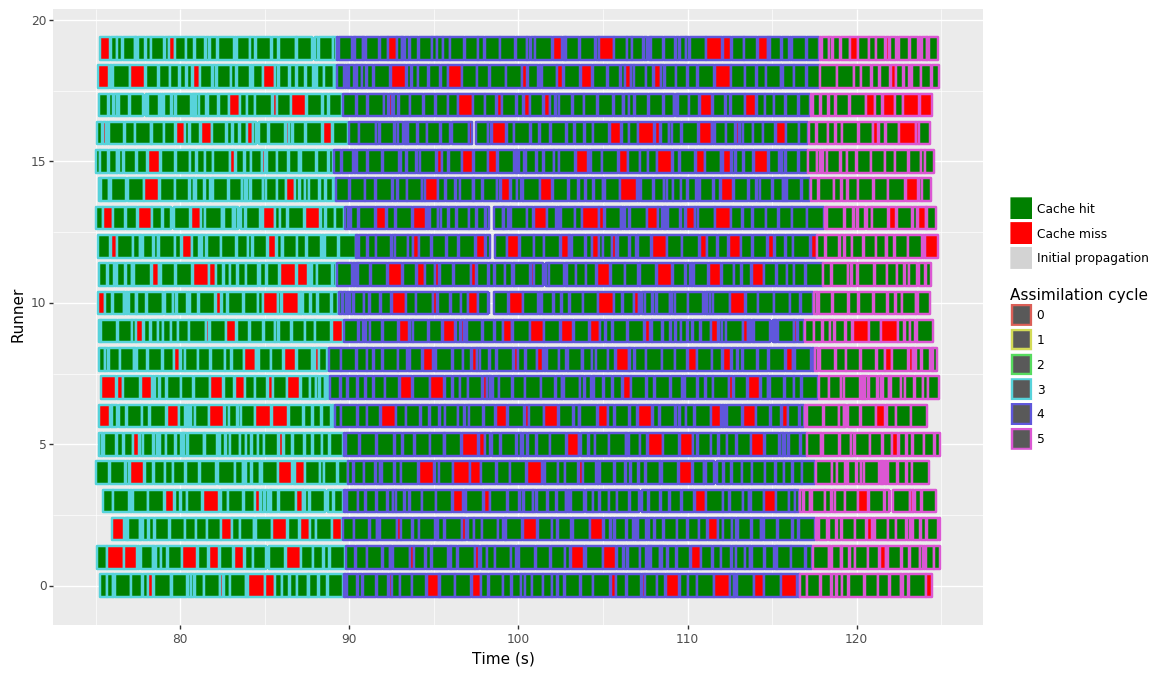

<ggplot: (8751143999534)>

In [89]:
p = ggplot(o[(o['region'] == 'Propagation') & (o['Assimilation_cycle'] < 6)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

p += xlim(75,125)



p += theme(figure_size = (12, 8))
p += labs(fill='')
p += labs(color='Assimilation cycle')


p

Question: how many of the speculative ones are thrown away?

In [90]:
o[o['region'] == 'Propagation'].groupby('Assimilation cycle').count()

rank  start_time  end_time  region  parameter_open  \
Assimilation cycle                                                       
0                     20          20        20      20              20   
1                   1000        1000      1000    1000            1000   
2                   1001        1001      1001    1001            1001   
3                   1003        1003      1003    1003            1003   
4                   1008        1008      1008    1008            1008   
5                   1007        1007      1007    1007            1007   
6                   1000        1000      1000    1000            1000   
7                   1000        1000      1000    1000            1000   
8                    138         138       138     138             138   

                    parameter_close    id  Parent  start_time_s  end_time_s  \
Assimilation cycle                                                            
0                                20    20      20            20          20   
1                              1000  1000    1000          1000        1000   
2                              1001  1001    1001          1001        1001   
3                              1003  1003    1003          1003        1003   
4                              1008  1008    1008          1008        1008   
5                              1007  1007    1007          1007        1007   
6                              1000  1000    1000          1000        1000   
7                              1000  1000    1000          1000        1000   
8                               138   138     138           138         138   

                    state load  Assimilation_cycle  state_load  
Assimilation cycle                                              
0                           20                  20          20  
1                         1000                1000        1000  
2                         1001                1001        1001  
3                         1003                1003        1003  
4                         1008                1008        1008  
5                         1007                1007        1007  
6                         1000                1000        1000  
7                         1000                1000        1000  
8                          138                 138         138

(assilation cycle 8 was not yet finished when we did the timing. assimilation cycles 0 and 1 are init only)
As we can see we make up to 8 extrapropagations in this artificial case. (Assimilatio cycle 4...)
- Lets closer inspect assimilation cycle 4 (the blue one in the upper char)
    - how many particles are kicked of via speculation for this cycle?
    

In [91]:
# When does assmilation cycle 3 finish?
finish_3 = o[(o['region'] == 'Propagation') & (o['Assimilation cycle'] == 3)]['end_time_s'].max()
print('max:', finish_3)
o[(o['region'] == 'Propagation') & (o['Assimilation cycle'] == 3) & (o['id'] == 12)]  # its on runner 12

max: 90.36724594799999


rank    start_time      end_time       region  parameter_open  \
883      0  63385.683791  64155.777744  Propagation            3005   
891      0  64189.813402  64391.902586  Propagation            3063   
899      0  64425.648834  64914.732271  Propagation            3077   
907      0  64950.093111  65366.181723  Propagation            3118   
915      0  65397.752134  66047.840257  Propagation            3154   
923      0  66077.516565  66139.601486  Propagation            3204   
931      0  66169.135432  66914.221147  Propagation            3210   
939      0  66944.714628  67039.799905  Propagation            3270   
947      0  67069.305492  67109.385436  Propagation            3284   
955      0  67139.549658  67777.638668  Propagation            3286   
963      0  67808.376555  68658.463155  Propagation            3332   
971      0  68688.965268  69391.051190  Propagation            3402   
979      0  69425.403182  70247.487247  Propagation            3451   
987      0  70277.849891  71186.933362  Propagation            3519   
995      0  71216.962773  71479.049938  Propagation            3596   
1003     0  71509.820567  71965.904640  Propagation            3618   
1011     0  71996.017188  72029.091984  Propagation            3651   
1021     0  72120.519703  73005.607519  Propagation            3656   
1029     0  73036.207629  73184.279792  Propagation            3736   
1037     0  73214.874895  73813.961707  Propagation            3742   
1045     0  73846.342965  74566.431777  Propagation            3793   
1053     0  74596.970487  75072.064643  Propagation            3856   
1061     0  75105.081790  75862.167728  Propagation            3884   
1069     0  75893.003658  76243.088419  Propagation            3955   
1077     0  76274.635861  77175.734692  Propagation            3988   
1085     0  77206.600217  77600.696917  Propagation            4059   
1093     0  77632.359498  77752.436490  Propagation            4091   
1101     0  77783.782281  78404.873351  Propagation            4104   
1109     0  78436.154252  78677.249732  Propagation            4162   
1117     0  78710.450934  78725.523357  Propagation            4176   
1125     0  78756.398191  79673.488884  Propagation            4182   
1133     0  79705.146574  80068.235605  Propagation            4256   
1141     0  80100.312665  80670.392687  Propagation            4287   
1149     0  80701.942747  81108.032042  Propagation            4338   
1157     0  81139.352001  81271.430177  Propagation            4372   
1165     0  81304.225948  81524.317986  Propagation            4383   
1173     0  81557.955850  82378.043459  Propagation            4402   
1181     0  82410.851963  83287.938933  Propagation            4460   
1189     0  83324.117283  83992.206703  Propagation            4527   
1197     0  84024.571645  84237.658782  Propagation            4587   
1205     0  84270.102611  85137.187395  Propagation            4605   
1213     0  85169.958177  85688.048991  Propagation            4680   
1221     0  85720.590884  85987.675015  Propagation            4711   
1229     0  86020.534727  86062.613227  Propagation            4738   
1237     0  86094.504483  86874.596647  Propagation            4743   
1245     0  86906.951670  87436.041631  Propagation            4792   
1253     0  87469.043625  88319.130223  Propagation            4838   
1261     0  88352.173598  88517.254351  Propagation            4905   
1269     0  88550.120720  89316.209280  Propagation            4921   
1277     0  89368.155339  90367.245948  Propagation            4986   

      parameter_close  id  Assimilation cycle  Parent  start_time_s  \
883              3005  12                   3    1225     63.385684   
891              3063  12                   3    2294     64.189813   
899              3077  12                   3    1225     64.425649   
907              3118  12                   3    2940     64.950093   
915              3154  12    

So after 90.36 seconds we finish cycle 3. How many of cycle 4 are started before (speculatively)?

In [92]:
o[(o['region'] == 'Propagation') & (o['Assimilation cycle'] == 4) & (o['start_time_s'] < finish_3)].count()

rank                  46
start_time            46
end_time              46
region                46
parameter_open        46
parameter_close       46
id                    46
Assimilation cycle    46
Parent                46
start_time_s          46
end_time_s            46
state load            46
Assimilation_cycle    46
state_load            46
dtype: int64

46 are started speculatively. Only 8 of them were not useful does this make sense?

/home/friese/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_rect : Removed 4830 rows containing missing values.


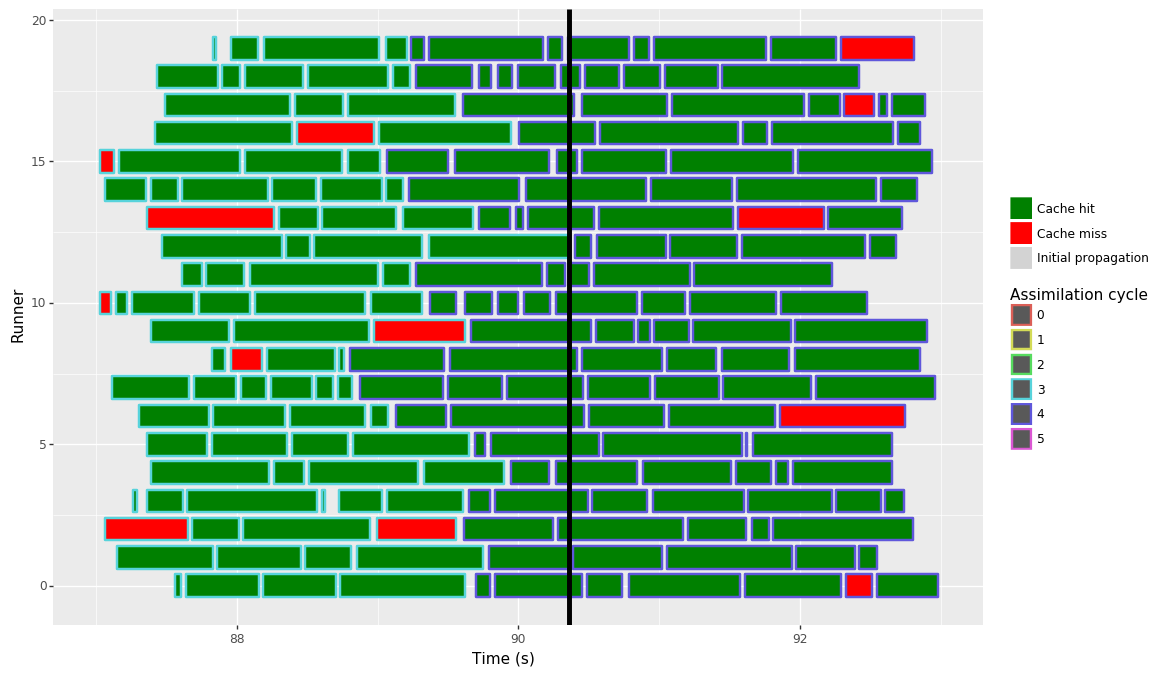

<ggplot: (8751146330052)>

In [93]:
p = ggplot(o[(o['region'] == 'Propagation') & (o['Assimilation_cycle'] < 6)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

p += xlim(87,93)


p += geom_vline(xintercept=90.36, size=2)
p += theme(figure_size = (12, 8))
p += labs(fill='')
p += labs(color='Assimilation cycle')


p

Black line is where the old assimilation cycle was finished. 
After counting by hand this seems to be true

In [94]:
# the same without speculative propagation:


In [95]:
o = preprocess('STATS.jean-zay/STATS.1000.no-speculative')

Found data from 20 runners


/home/friese/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_rect : Removed 3266 rows containing missing values.


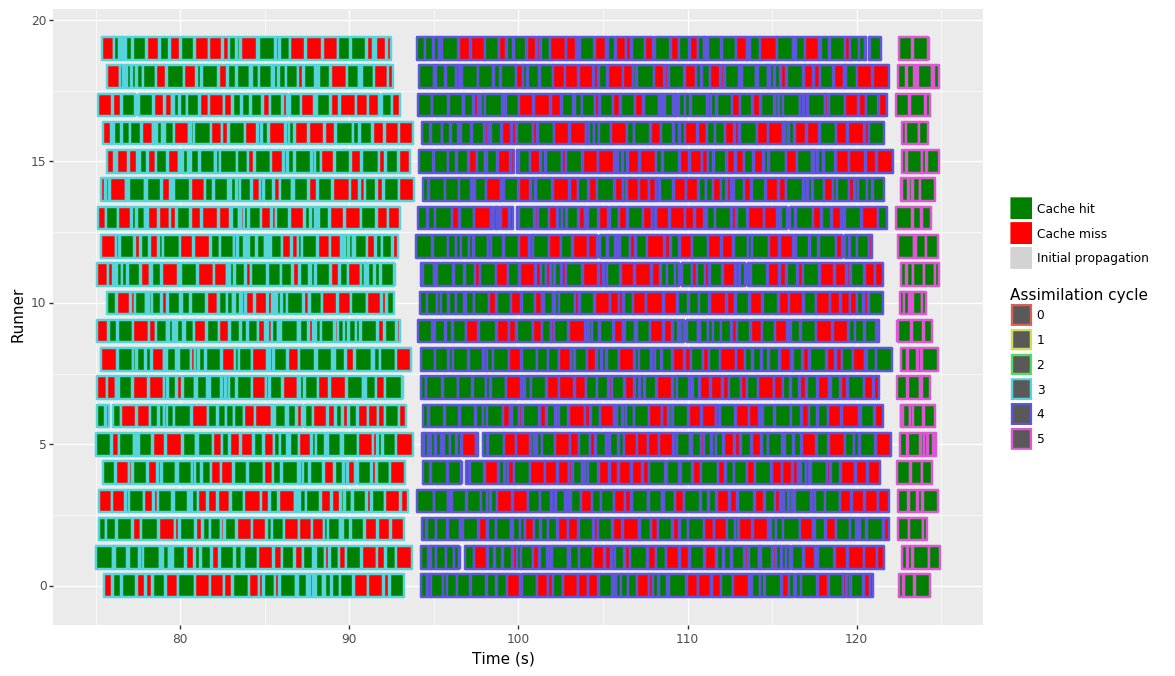

<ggplot: (8751135120375)>

In [96]:
p = ggplot(o[(o['region'] == 'Propagation') & (o['Assimilation_cycle'] < 6)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

p += xlim(75,125)



p += theme(figure_size = (12, 8))
p += labs(fill='')
p += labs(color='Assimilation cycle')


p

We directly see much more slack time. Further the first iterations take much longer. before iteration3 was completed at 90.4 seconds. Now it is completed at roughly 94 seconds. Obviously we need to get better numbers for comparism. So lets have a look at the time per assimilation cycle:

In [97]:
gr = o[o['region'] == 'Propagation'].groupby('Assimilation cycle')
print('Assimilation cycle time in seconds, no speculative')
gr.max()['end_time_s'] - gr.min()['start_time_s']

Assimilation cycle time in seconds, no speculative


Assimilation cycle
0     4.709556
1    28.875903
2    27.447018
3    27.505955
4    28.239541
5    27.250632
6    27.138440
7    23.367901
dtype: float64

In [98]:
s = preprocess('STATS.jean-zay/STATS.1000')  # with speculative

Found data from 20 runners


In [99]:
print('Assimilation cycle time in seconds, no speculative')
gr = s[s['region'] == 'Propagation'].groupby('Assimilation cycle')
gr.max()['end_time_s'] - gr.min()['start_time_s']

Assimilation cycle time in seconds, no speculative


Assimilation cycle
0     7.615896
1    31.571569
2    28.184396
3    27.801327
4    29.253980
5    28.171919
6    27.571540
7    27.437109
8     4.555641
dtype: float64

Oh I see: I may not count like this since they are interlaced. Counting last Finished and last beginning should be better (REM: the last begins after the last prescheduled was finished...

In [100]:
gr = s[s['region'] == 'Propagation'].groupby(['Assimilation cycle', 'id'])
print('Assimilation cycle time in seconds, no speculative')
gr.max()['end_time_s'].groupby('Assimilation cycle').max() - gr.min()['start_time_s'].groupby('Assimilation cycle').max()  #FIXME: group runner wise!

Assimilation cycle time in seconds, no speculative


Assimilation cycle
0     0.621196
1    24.644845
2    27.375409
3    26.547984
4    27.654189
5    26.690737
6    26.362371
7    26.177764
8     3.170356
dtype: float64

even calculating the values like this is no good meassure. we are about 2/50 faster since :

yes there is performance gain. but its not that high if, like in this case, every runner does 1000/20=50 particles on average each cycle. I think on mean each runner would wait the time of about 2 propagations that we now save. so '2/50 faster' - this is not a lot (especially if there are some useless particles atm). Obviously that should be tunable by having more runners or less particles....

or also by using all particles

### What about cache misses and cache hits?
- is there a bug?

In [101]:
s[s['Assimilation cycle'] == 4].groupby('state_load').count()

rank  start_time  end_time  region  parameter_open  \
state_load                                                       
Cache hit    840         840       840     840             840   
Cache miss   168         168       168     168             168   

            parameter_close   id  Assimilation cycle  Parent  start_time_s  \
state_load                                                                   
Cache hit               840  840                 840     840           840   
Cache miss              168  168                 168     168           168   

            end_time_s  state load  Assimilation_cycle  
state_load                                              
Cache hit          840         840                 840  
Cache miss         168         168                 168

In [102]:
o[o['Assimilation cycle'] == 4].groupby('state_load').count()

rank  start_time  end_time  region  parameter_open  \
state_load                                                       
Cache hit    598         598       598     598             598   
Cache miss   402         402       402     402             402   

            parameter_close   id  Assimilation cycle  Parent  start_time_s  \
state_load                                                                   
Cache hit               598  598                 598     598           598   
Cache miss              402  402                 402     402           402   

            end_time_s  state load  Assimilation_cycle  
state_load                                              
Cache hit          598         598                 598  
Cache miss         402         402                 402

So the speculative version shows 84% cache hits while w/o we only achieve 60% . Why is this like this?
is this an artifact of randomness?

At first glance I could detect no errors in the server logging misses and also not in the script detecting it. So lets do another measurement to get a fealing of the spread in cache hits in the random example:

In [103]:
o2 = preprocess('STATS.jean-zay/STATS.1000.no-speculative.2')

Found data from 20 runners


In [104]:
o2[o2['Assimilation cycle'] == 4].groupby('state_load').count()

rank  start_time  end_time  region  parameter_open  \
state_load                                                       
Cache hit    440         440       440     440             440   
Cache miss   560         560       560     560             560   

            parameter_close   id  Assimilation cycle  Parent  start_time_s  \
state_load                                                                   
Cache hit               440  440                 440     440           440   
Cache miss              560  560                 560     560           560   

            end_time_s  state load  Assimilation_cycle  
state_load                                              
Cache hit          440         440                 440  
Cache miss         560         560                 560

oh lala that looks even worse....

In [105]:
s2 = preprocess('STATS.jean-zay/STATS.1000.2')
s2[s2['Assimilation cycle'] == 4].groupby('state_load').count()

Found data from 20 runners


rank  start_time  end_time  region  parameter_open  \
state_load                                                       
Cache hit    596         596       596     596             596   
Cache miss   407         407       407     407             407   

            parameter_close   id  Assimilation cycle  Parent  start_time_s  \
state_load                                                                   
Cache hit               596  596                 596     596           596   
Cache miss              407  407                 407     407           407   

            end_time_s  state load  Assimilation_cycle  
state_load                                              
Cache hit          596         596                 596  
Cache miss         407         407                 407

/home/friese/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_rect : Removed 3170 rows containing missing values.


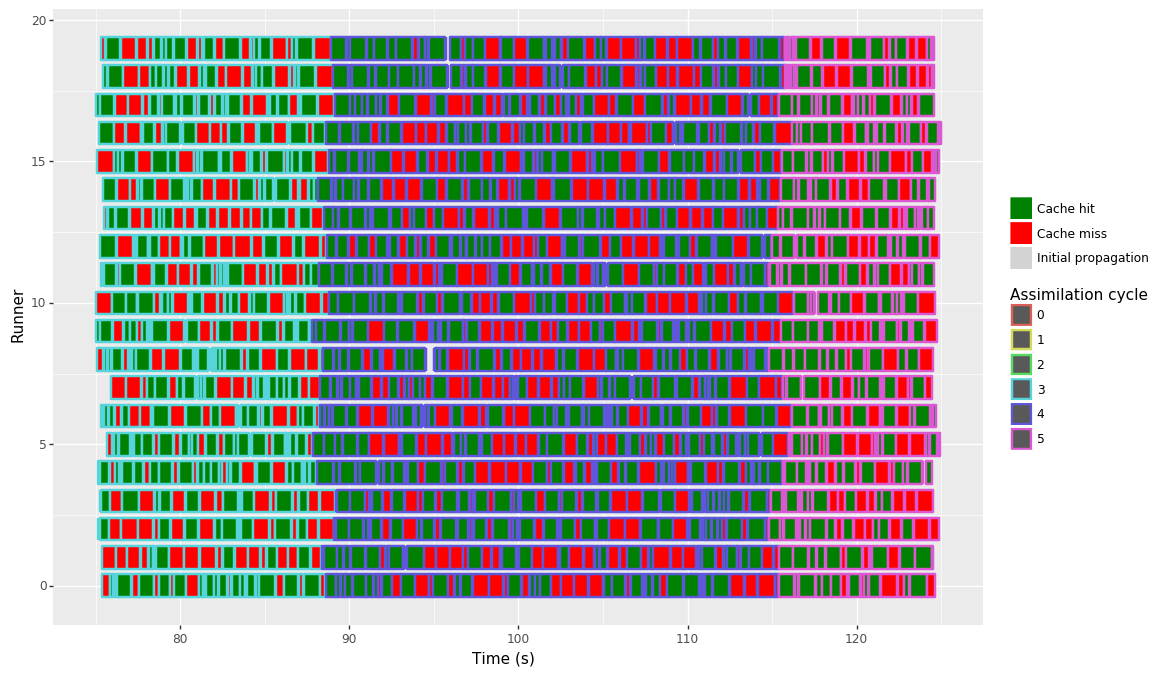

<ggplot: (8751134907121)>

In [106]:
p = ggplot(s2[(s2['region'] == 'Propagation') & (s2['Assimilation_cycle'] < 6)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

p += xlim(75,125)



p += theme(figure_size = (12, 8))
p += labs(fill='')
p += labs(color='Assimilation cycle')


p

## 24.8.2021: Test that the serverside code runs fast enough.... Check the response times for the bigger use cases!

In [3]:
def server_response_charts(stats):
    STATS = stats
    data1 = !! grep -h REQ $stats/*/trace.runner-*-app.0.csv 
    data2 = !! grep -h PUSH_WEIGHT_TO_SERVER $stats/*/trace.runner-*-head.0.csv 
    data3 = !! grep -h REQ $stats/*/trace.runner-*-head.0.csv 
    al = data1 + data2 + data3

    ps = []
    df_req = pd.read_csv(StringIO('\n'.join(al)), names=["rank", "start_time", "end_time", "region", "parameter_open", "parameter_close"])
    df_req['Duration (ms)'] = (df_req['end_time'] - df_req['start_time'])
    df_req = df_req[df_req['region'] != '_REQ_RUNNER_LIST']
    df_req.loc[df_req['region'] == '_DELETE_REQ', 'region'] = 'Delete request'
    df_req.loc[df_req['region'] == '_PREFETCH_REQ', 'region'] = 'Prefetch request'
    df_req.loc[df_req['region'] == '_PUSH_WEIGHT_TO_SERVER', 'region'] = 'Push weight to server'
    df_req.loc[df_req['region'] == '_JOB_REQUEST', 'region'] = 'Job request'


    p = ggplot(df_req)
    p += geom_boxplot(aes(x='region', y='Duration (ms)'))
    p += theme(axis_text_x=element_text(rotation=45, hjust=1))
    p += scale_y_log10()
#p += ggtitle("Server response time")
    p += labs(x='')

    p += theme(figure_size = (4, 3))
    ps.append(p)



    runner = '000'
    t_pull = 'Load state from PFS into cache'
    t_push = 'Write state from cache into PFS'
    t_local = 'Load state from cache'

    df_head = pd.read_csv(f'{STATS}/runner-{runner}/trace.runner-{runner}-head.0.csv')
    df_head['duration (ms)'] = df_head['end_time'] - df_head['start_time']
    df_head['process'] = 'helper process'
    df_app = pd.read_csv(f'{STATS}/runner-{runner}/trace.runner-{runner}-app.0.csv')
    df_app['process'] = 'model process'
    df_app = df_app[df_app['region'] != '_WAIT_HEAD']
    df_app['cat'] = df_app['region'].copy()
    df_app.loc[df_app['region'] == '_CALC_WEIGHT', 'region'] = 'Weight calculation'
    df_app.loc[df_app['region'] == '_CHECK_LOCAL', 'region'] = 'check if parent state local'
    df_app.loc[df_app['region'] == '_STORE', 'region'] = 'copy model state\ninto local ram disk'
    df_app.loc[df_app['region'] == '_PUSH_WEIGHT_TO_HEAD', 'region'] = 'send weight\nto worker processes'
    df_app.loc[df_app['region'] == '_INIT', 'region'] = 'init'
    df_app.loc[df_app['region'] == '_JOB_REQUEST', 'region'] = 'Request job from server'
    df_app.loc[df_app['region'] == '_LOAD', 'region'] = t_local
    df_app.loc[df_app['region'] == 'Propagation', 'region'] = "Propagation"
    df_head.loc[df_head['region'] == '_DELETE_REQ', 'region'] = 'delete request'
    df_head.loc[df_head['region'] == '_PREFETCH_REQ', 'region'] = 'prefetch request'
    df_head.loc[df_head['region'] == '_PUSH_WEIGHT_TO_SERVER', 'region'] = 'push weight to server'
    df_head.loc[df_head['region'] == '_JOB_REQUEST', 'region'] = 'job request'
    df_head.loc[df_head['region'] == '_COPY_STATE_FROM_PFS', 'region'] = t_pull
    df_head.loc[df_head['region'] == '_PUSH_STATE_TO_PFS', 'region'] = t_push





    df_app['oo'] = 1
    df_head['oo'] = 1
    good_cats = ['Weight calculation', 'runner idle', 'Request job from server', 'Propagation', t_local, t_pull, t_push]
    for idx, cat in enumerate(good_cats):
        df_app.loc[df_app['region'] == cat, 'oo'] = -idx
        df_head.loc[df_head['region'] == cat, 'oo'] = -idx
        
    df_all = pd.concat([df_app, df_head])
    df_all['start_time_s'] = df_all['start_time']/1000
    df_all['end_time_s'] = df_all['end_time']/1000




# runner trace
    p = ggplot(df_all[df_all['region'].isin(good_cats)])
    p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='reorder(region, oo)',
                       ymax='reorder(region, oo)',
                       fill='reorder(region, oo)', colour='reorder(region, oo)',
                      ), 
                   size=10, alpha=1)
    p += guides(fill=False, colour=False)
    p += xlab('Time (s)')
    p += theme(figure_size = (12, 4))

    xs = 377
    xe = 530.5
    xxx=xe + 40



    p += geom_hline(aes(yintercept=2.5),  linetype = "dashed")




    p += scale_y_discrete(expand=(0,1.5, 0,1.5))
    p += ylab('')
    ps.append(p)



# p2p vs pfs
    df_head['category'] = df_head['region']

    p = ggplot(df_head[(df_head['region'] == t_pull) | (df_head['region'] ==  t_push) | (df_head['region'] == t_local) ])
    p = ggplot(df_head)
    p += geom_boxplot(aes(x='category', y='duration (ms)'))

    p += xlab('')
    p += theme(figure_size = (4, 3))
    p += theme(axis_text_x=element_text(rotation=45, hjust=1))


    ps.append(p)
    return ps
# TODO: chart with all the server times req times von app core und head. Done


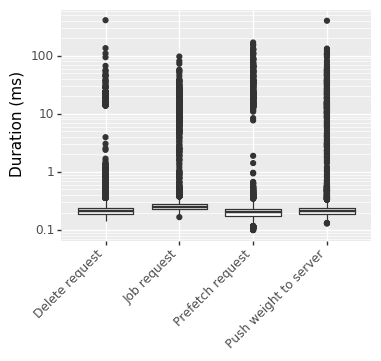

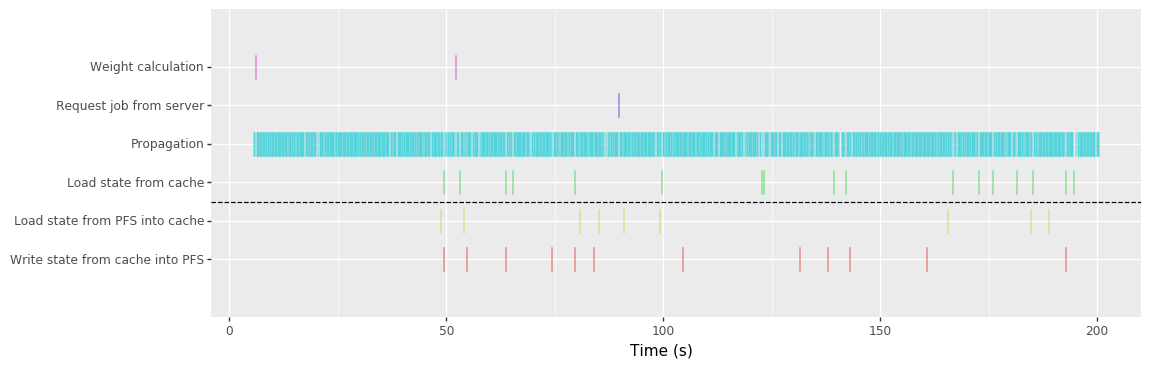

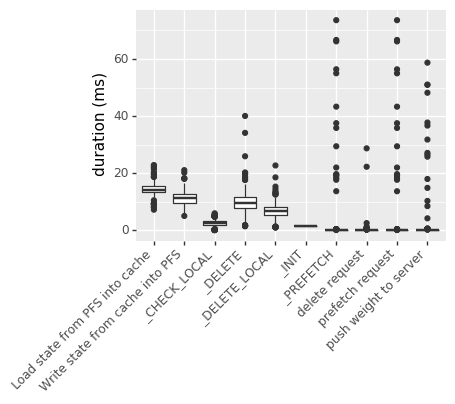

[<ggplot: (8743544943629)>,
 <ggplot: (8743497723209)>,
 <ggplot: (8743497727004)>]

In [6]:
server_response_charts('STATS.jean-zay/STATS.1000')

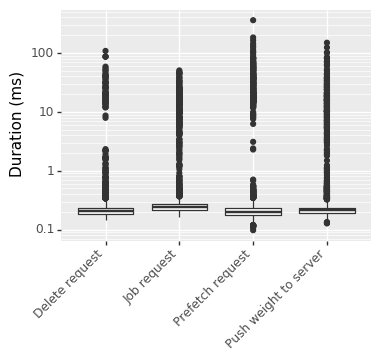

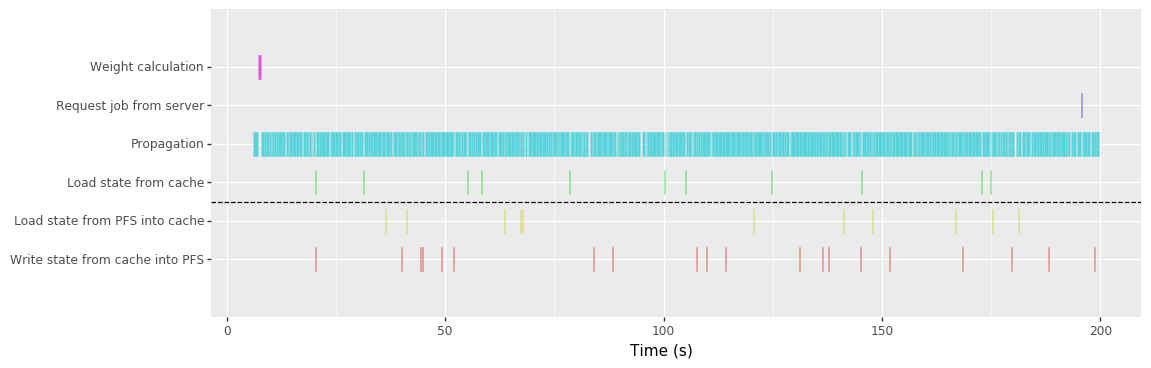

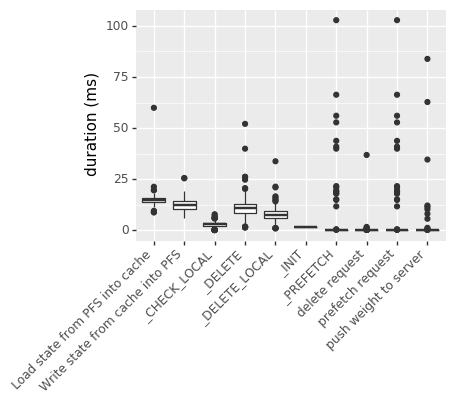

[<ggplot: (8743527509646)>,
 <ggplot: (8743497061443)>,
 <ggplot: (8743496919830)>]

In [7]:
server_response_charts('STATS.jean-zay/STATS.1000.2')

Ok seems to be fast enough for 1 k members. TODO: Need to go bigger probably now... Lets try 10K members. Script should be ready and can be launched this afternoon

Problem: Bug, delete request crash it. -- effectively it does not find a state to delete. one is probably the currently calculated, one

## 7.9.2021
It turns out this bug is related to many runners that are not finishing (at least in the first iteration). this occurs with 10 k members. Probably using less members will fix this. using a timeout of 60*30s for the runners also fixes gthis (60s was too few timeout)

Correcture: did the run again and it failed again. I guess there is a bug in error handling! As soon as stuff is restarted some caches overflow! - blacklist too large? need to push out stuff that crashed?


... my fix (573be36ab329a4f0a790af52775b59ebb07b53cc) seems not to work but the server can at least recover from the latest checkpoint.... feeling is still that it helped partly...

maybe simply need larger cache since there seem to be bad race conditions somewhere. My bet is: fs over charged

und ausserdem hab ich noch einen schoenen deadlock fall in melissap2p ausgegraben der auftritt wenn man mit so 10k partikeln laufen laesst und 200 runnern (ich Filesystem zeiten mess ich gleich mal, aber ich denke das wird gut latenz reinbringen und zu witzigen race conditions fuehren) 

Also was ich beobachte: der server schmiert nach random zeiten ab weil er nichts zu deleten findet.
Der server ist so programmeirt nie was zu deleten was grad noch am laufen ist oder was geprefetcht war.

Why is it still not finding what to delete?

Followiing Scenario:
- Runner requests job to do. --> 2 states in state cache (one input, one output)
- Runner requests job to prefetch --> 2 + 1=3 states in cache
- Runner app core pushes weight to runner head --> still 3 undeletable states in state cache
- Runner app core requests new job to do --> now 4 jobs are in the local cache.
- Runner head requests job to prefetch --> 5 undeletable jobs in local cache...

- ... if the weight message is not received by the server in time the runner cache can overflow.


--- aber da sind doch sperren drin (kann nicht einen state raus schicken waehrend noch nicht der letzte da war oder?) ... vlt muss ich nur auf 5 states oder so stellen? -- kann weight pushen zum head blocken?

~THIS is it! needs to be set to 5 states!~  --> turns out to be wrong in the following

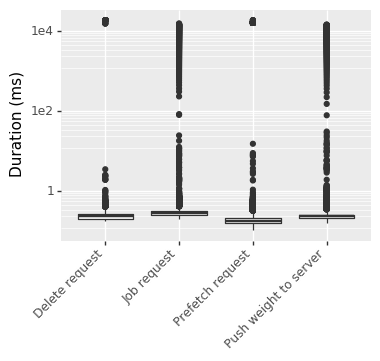

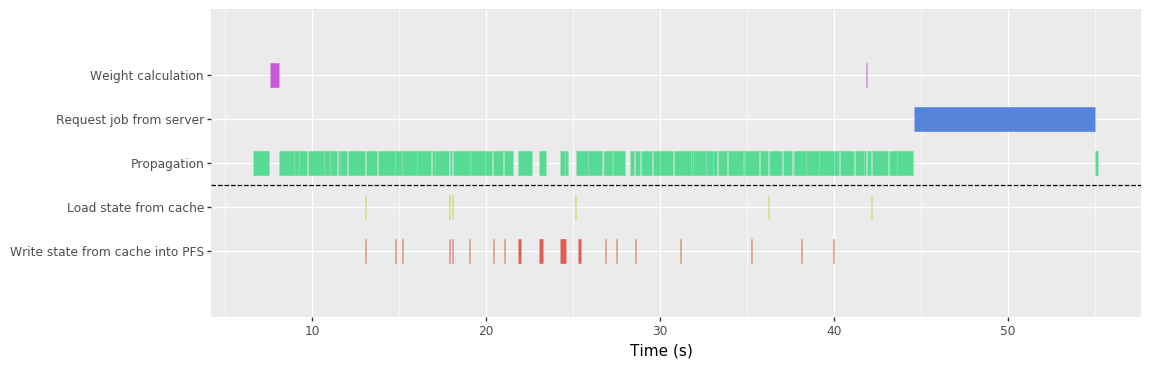

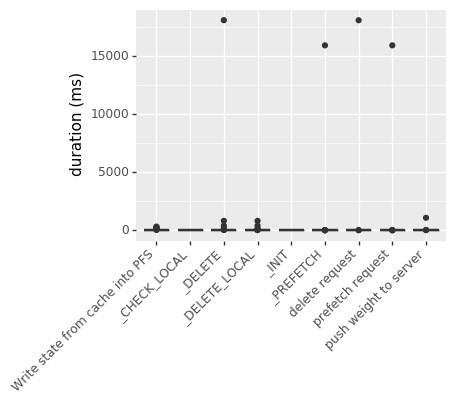

[<ggplot: (8756167379728)>,
 <ggplot: (8756163520811)>,
 <ggplot: (8756163530759)>]

In [4]:
server_response_charts('STATS.jean-zay/STATS.10000')

In [5]:
s3 = preprocess('STATS.jean-zay/STATS.10000')
s3[s3['Assimilation cycle'] == 4].groupby('state_load').count()

Found data from 200 runners


Empty DataFrame
Columns: [rank, start_time, end_time, region, parameter_open, parameter_close, id, Assimilation cycle, Parent, start_time_s, end_time_s, state load, Assimilation_cycle]
Index: []

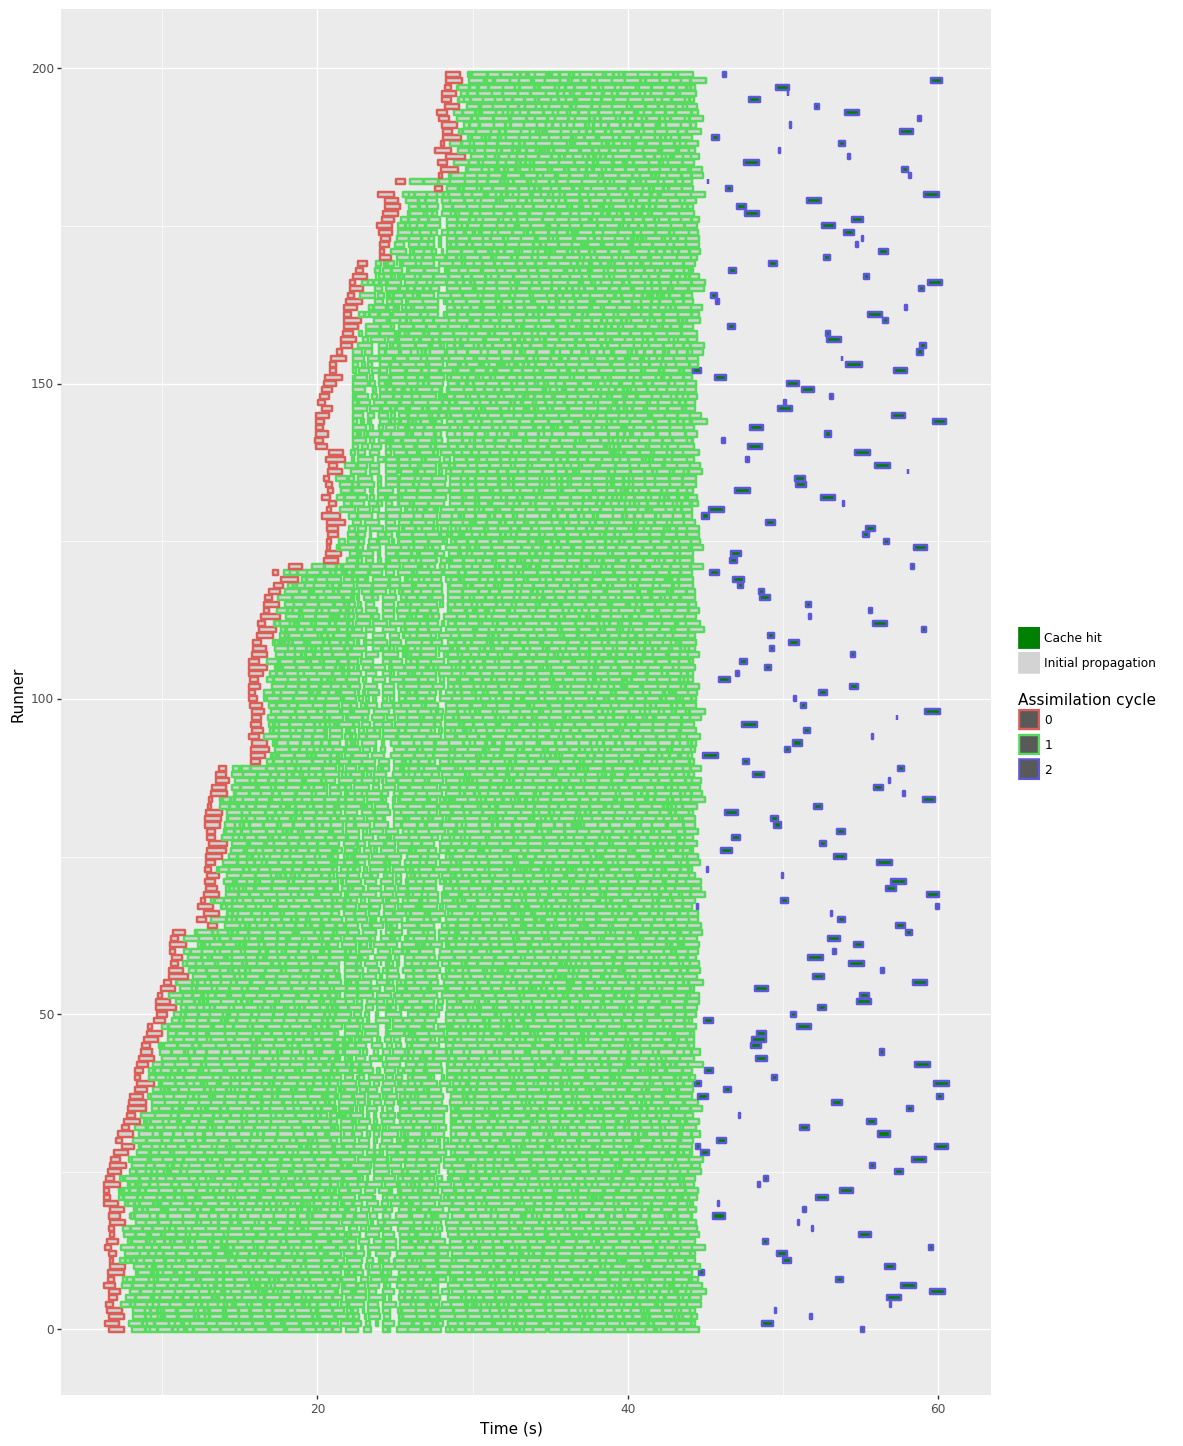

<ggplot: (8756163240241)>

In [8]:
p = ggplot(s3[(s3['region'] == 'Propagation') & (s3['Assimilation_cycle'] < 6)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

#p += xlim(75,125)



p += theme(figure_size = (12, 18))
p += labs(fill='')
p += labs(color='Assimilation cycle')


p

Seems like the 2nd propagation did not finish... lets inspect the data a bit more:

In [13]:
s3['Assimilation cycle'].max()

2

Ok there is no data for anothe assimilation cycle. what a pity! Lets check the logs since the trace also looks strange.... Furthermore it was taking the capture already after 60s it seems. This obviously is too short!

further we also see that there was a crash at some point.... so what we assumed that we fixed it is not true. lets try with a bigger cache though

Looks by the way as if there is no lock. so basically an indefinit numbers of job requests may be sent before a weight is completely pushed to the server through the head

In [16]:
s4 = preprocess('STATS.jean-zay/STATS.10000.2')
s4[s4['Assimilation cycle'] == 4].groupby('state_load').count()

Found data from 148 runners


Empty DataFrame
Columns: [rank, start_time, end_time, region, parameter_open, parameter_close, id, Assimilation cycle, Parent, start_time_s, end_time_s, state load, Assimilation_cycle]
Index: []

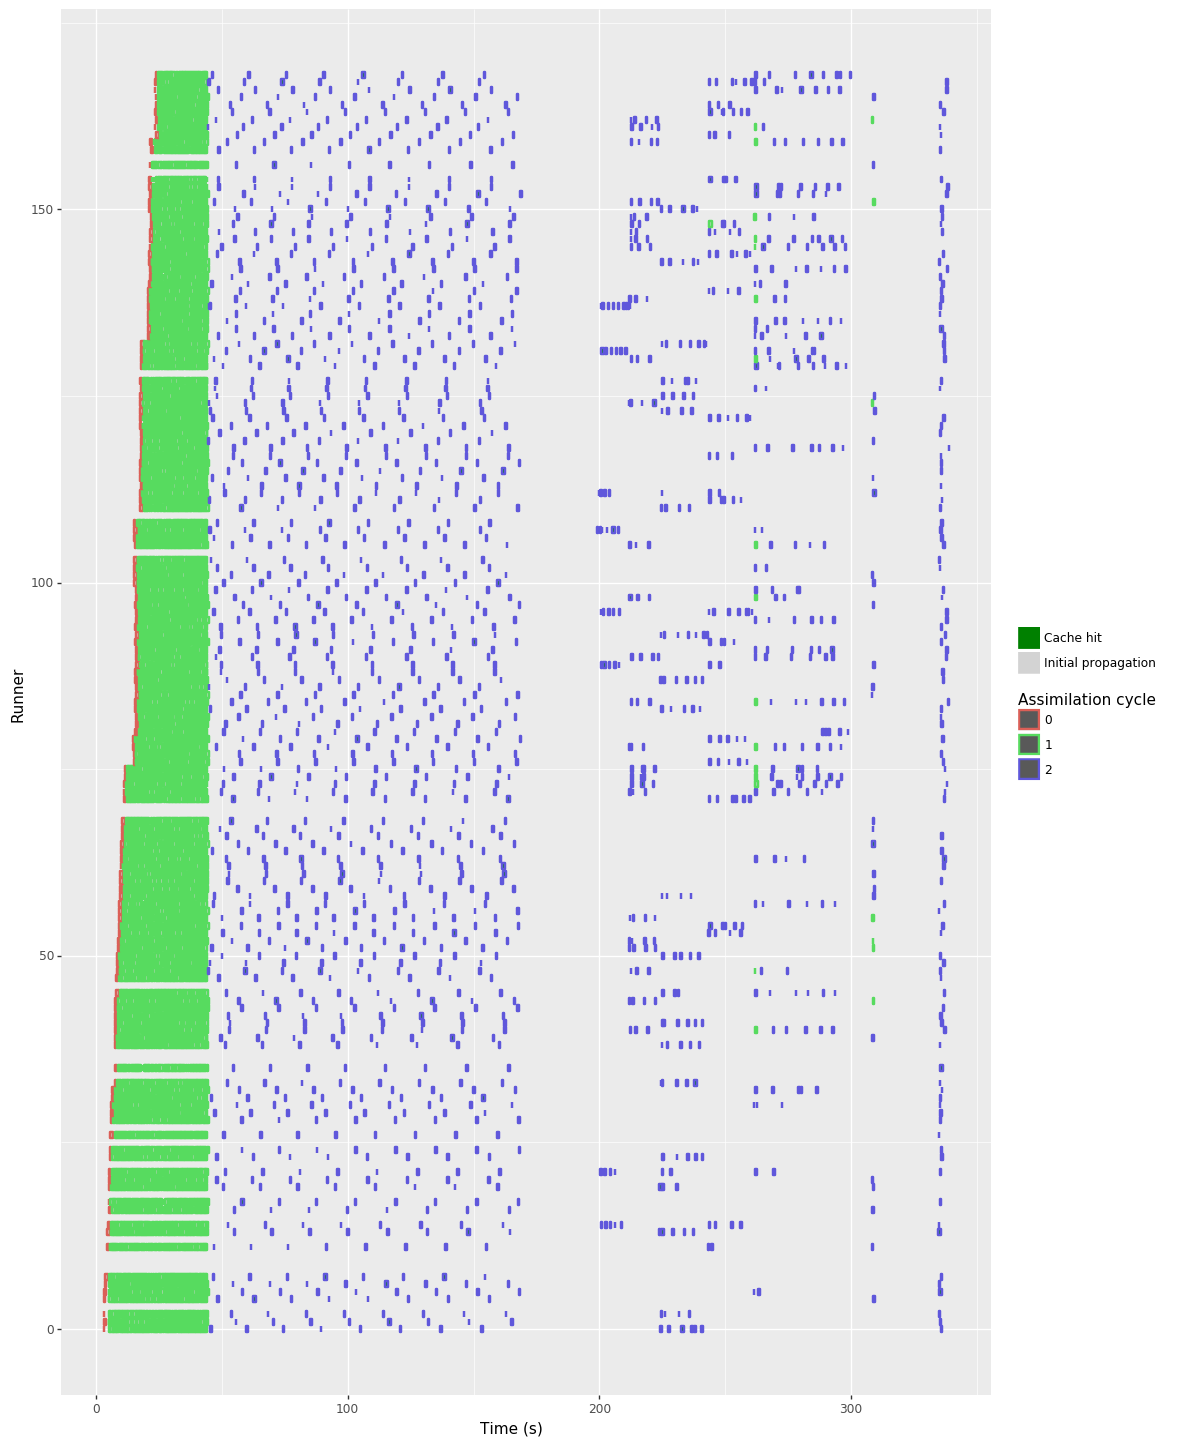

<ggplot: (8756119581377)>

In [17]:
p = ggplot(s4[(s4['region'] == 'Propagation') & (s4['Assimilation_cycle'] < 6)])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

#p += xlim(75,125)



p += theme(figure_size = (12, 18))
p += labs(fill='')
p += labs(color='Assimilation cycle')


p

*REM: we did not copy all runners in the local folder!*

only cache hits at least! this is nice but: it looks like the first iteration took really long to finish and all 2 iteration jobs are prescheduled ones? further is maybe the FS taking long time? strange!

maybe we should loawer the timeout so crashing sttuff is reastarted quickly ;)

Maybe we should lower the timeout!
--> no in the logs we see too that the weights do not arrive!
```
, t: 2
id: 15428
) on 99
[ 1199.250 ] Received weight 0.7775653632828051 for t: 3
id: 34107
 .
[ 1199.250 ] Can we do an update? len(alpha_weights)=89, sum=89, len(unscheduled_jobs)=0, sum=0, stealable_jobs=0)
[ 1199.250 ] len state_weights: 25141
[ 1199.253 ] len(this_cycle) 10298
[ 1199.263 ] ---- Resampling from particles with t=2 ----
[ 1199.353 ] Drawing 5102 particles by chance
[ 1199.369 ] out_parts [t: 2
 id: 10005 t: 2
```

so it really is about the mpi send. Since there is no ack and sometimes the heads are occupied really long writing / reading stuff the messages do not arrive in time...


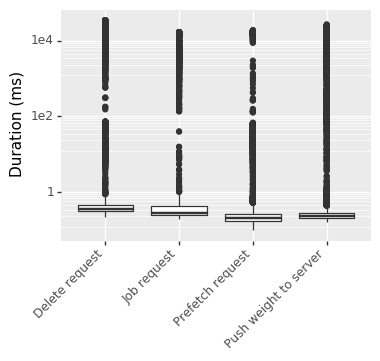

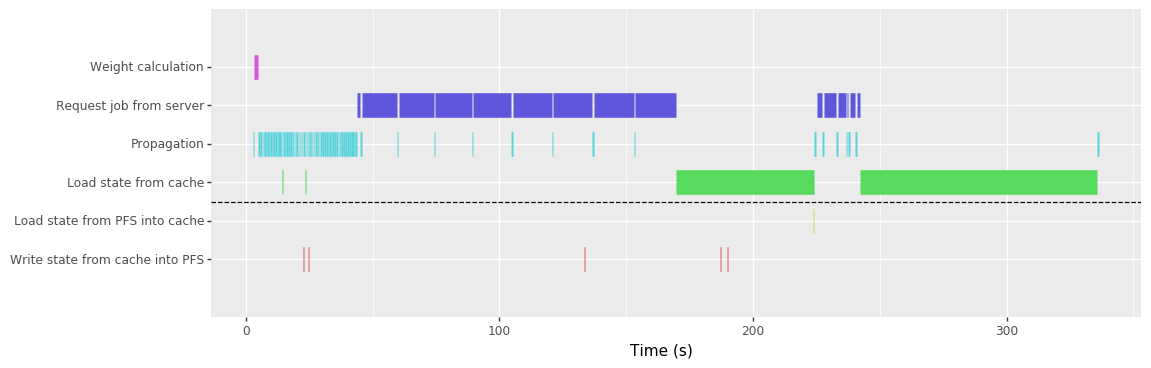

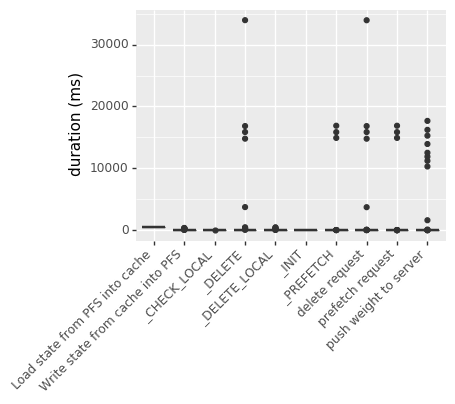

[<ggplot: (8756119762923)>,
 <ggplot: (8756149725260)>,
 <ggplot: (8756163021451)>]

In [19]:
server_response_charts('STATS.jean-zay/STATS.10000.2')

Should be clear from the 3rd chart: sometimes things use tenth of seconds. and this is only on one runner.... so the pressure on the fs gets too high with 10k particles!

## 15.9. TODO: compare what is in the experiments runner activity section on the p2p paper
we should compare the nmbers runners are idle due to the resampling. this should be much less now (was about 12 percent at the beginning ;)

## 21.12.2021 How wrong are the weights?

$\hat{w}_{i,t}^{M'} = \frac{w_{i,t}}{\sum_{0 \leq j < M'} w_{j,t}}$

-->

$\hat{w}_{i,t}^{M'} - \hat{w}_{i,t}  = \frac{w_{i,t}}{\sum_{0 \leq j < M'} w_{j,t}} - \frac{w_{i,t}}{\sum_{0 \leq j < M} w_{j,t}} = w_{i,t} \left( \frac{1}{\sum_{0 \leq j < M'} w_{j,t}} - \frac{1}{\sum_{0 \leq j < M} w_{j,t}} \right) $

$ = w_{i,t} \frac{\sum_{0 \leq j < M} w_{j,t} - \sum_{0 \leq j < M'} w_{j,t}}{\sum_{0 \leq j < M} w_{j,t} \cdot \sum_{0 \leq j < M'} w_{j,t}} = w_{i,t} \frac{\sum_{M' \leq j < M} w_{j,t} }{\sum_{0 \leq j < M} w_{j,t} \cdot \sum_{0 \leq j < M'} w_{j,t}}$



and now the relative error (we assume $M' < M, w_{i,t} > 0\ \ \ \forall i,t$): 

$1 - \frac{ \hat{w}_{i,t}}{\hat{w}_{i,t}^{M'} } = 1 - \frac{ \frac{w_{i,t}}{\sum_{0 \leq j < M} w_{j,t}}}{\frac{w_{i,t}}{\sum_{0 \leq j < M'} w_{j,t}} } = 1 - \frac{\sum_{0 \leq j < M'} w_{j,t}}{\sum_{0 \leq j < M} w_{j,t}} = \frac{\sum_{0 \leq j < M} w_{j,t} - \sum_{0 \leq j < M'} w_{j,t}}{\sum_{0 \leq j < M} w_{j,t}} = \frac{\sum_{M' \leq j < M} w_{j,t}}{\sum_{0 \leq j < M} w_{j,t}}$

With the limes of this term:
    
$ \text{lim}_{M'\rightarrow M}  \frac{\sum_{M' \leq j < M} w_{j,t}}{\sum_{0 \leq j < M} w_{j,t}} =  \frac{0}{\sum_{0 \leq j < M} w_{j,t}} = 0 $


## 22.12.21

debug speculative execution

Found data from 3 runners


/home/friese/miniconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/home/friese/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_rect : Removed 67 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


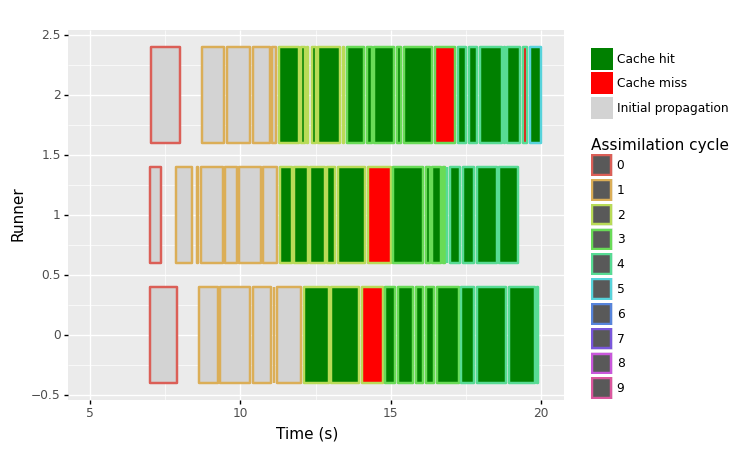

<ggplot: (1443910573800)>

In [12]:
tmp = preprocess('STATS')
p = ggplot(tmp[(tmp['region'] == 'Propagation')])
p += geom_rect(aes(xmin='start_time_s', xmax='end_time_s', ymin='id-.4',
                           ymax='id+.4', fill='state_load', color='factor(Assimilation_cycle)'), size = 1)#, fill='factor(Assimilation_cycle)'))

# plot in crashes if existing:

p += scale_fill_manual(values={'Cache hit': 'green', 'Cache miss': 'red', 'Initial propagation': 'lightgray'})
p += xlab('Time (s)')
p += ylab('Runner')

p += xlim(5, 20)



#p += theme(figure_size = (12, 18))
p += labs(fill='')
p += labs(color='Assimilation cycle')


p